### Задача 1.

Выберите несколько человек (не менее 5) с DS-потока по состоянию на осенний семестр и сравните их успеваемость методами дисперсионного анализа, рассмотрев оценки по всем практическим заданиям. Обратите внимание, что в отличии от примера с презентации в данном случае исследуемым фактором является человек, а задание &mdash; мешающий фактор.

In [133]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from tqdm.notebook import tqdm
import statsmodels.api as sm

%matplotlib inline

Мы знаем, что мы живем в реальном мире, поэтому результаты студентов не могут быть независимыми (хотя бы потому, что студенты посещают одни и те же лекции и семинары). Поэтому проведем факторный анализ для связных выборок.

In [3]:
X_1 = np.array('''17,25	16	16,75	13	33	25	26	20,5	27	28,75	27	17,5	25,5	12,5	7'''.replace(',', 
                                                                            '.').split('	'), dtype=float)
X_2 = np.array('''17	16,5	16	9,75	34	21	24	23	29	29,75	19	18,5	24	13	0'''.replace(',', 
                                                                            '.').split('	'), dtype=float)
X_3 = np.array('''18,25	15,5	15,3	12,5	32	24	23	19	27,5	29,25	0	29	26	14,5	6,5'''.replace(',', 
                                                                            '.').split('	'), dtype=float)
X_4 = np.array('''15,25	13	15,5	 13,5	35	28	27,5	22,5	27	28,75	37,5	28	28	13,5	5,5'''.replace(',', 
                                                                            '.').split('	'), dtype=float)
X_5 = np.array('''16	11	19,5	9	36	25	23,5	21,75	9	24,5	30	23	26,5	11	0'''.replace(',', 
                                                                          '.').split('	'), dtype=float)

In [10]:
samples = [X_1]
samples.append(X_2)
samples.append(X_3)
samples.append(X_4)
samples.append(X_5)
samples = np.array(samples)
samples.shape

(5, 15)

In [11]:
sps.friedmanchisquare(*samples)

FriedmanchisquareResult(statistic=3.63513513513517, pvalue=0.4576303029932729)

**Вывод:** эффект от студента дс-потока не зависит, пост-хок анализ проводить не имеет смысла.

### Задача 3.

Рассмотрим модель $X_{ij} = \mu + \alpha_i + \beta_j + \varepsilon_{ij}, i=1..n, j=1..k$ однофакторного дисперсионного анализа для случая связных выборок. Фактор отвечает за степень воздействия на объект, поэтому в качестве альтернативной гипотезы рассматривается $\mathsf{H}_1\colon \beta_1 \leqslant ... \leqslant \beta_k$. Исследуйте поведение мощности критериев Фридмана и Пейджа в зависимости от размера выборки, количества групп, а также вида распределения шума $\varepsilon_{ij}$, если на самом деле $\beta_j = j\beta$, где $\beta > 0$. 

Создадим сетки, на которых будем исследовать поведение мощности.

In [138]:
n_factor_grid = [3, 5, 7, 10]
n_sample_grid = [10, 20, 30, 50, 100]
distr_grid = [sps.norm, sps.norm(scale=5), sps.laplace, sps.cauchy]

Напишем функцию, которая будет считать частоту отвержений для критерия Фридмана и критерия Пейджа.

In [139]:
def count_power_factor_criterions(n_iter=2000, n_factor_grid=[10], n_sample_grid=[100], distr_grid=[sps.norm(scale=10)], 
                                  mu=100, alpha=0, beta_grid=np.linspace(0, 1, 11)):
    n_rejects_friedman = np.zeros(shape=(len(n_factor_grid), len(n_sample_grid), len(distr_grid), len(beta_grid)))
    n_rejects_page = np.zeros(shape=(len(n_factor_grid), len(n_sample_grid), len(distr_grid), len(beta_grid)))
    for i, n_factor in enumerate(n_factor_grid):
        for j, n_sample in enumerate(n_sample_grid):
            for k, distr in enumerate(distr_grid):
                for b, beta in tqdm(enumerate(beta_grid)):
                    eps = distr.rvs(size=(n_iter, n_factor, n_sample))
                    beta = np.linspace(beta, n_factor * beta, n_factor).reshape(1, n_factor, 1)
                    X = eps + mu + alpha + beta
                    for it in range(n_iter):
                        n_rejects_friedman[i][j][k][b] += (sps.friedmanchisquare(*X[it]).pvalue < 0.05)
                        n_rejects_page[i][j][k][b] += (sps.page_trend_test(X[it].T, method='exact').pvalue < 0.05)
                
    return n_rejects_friedman, n_rejects_page

In [148]:
n_rejects_friedman, n_rejects_page = count_power_factor_criterions(n_factor_grid=n_factor_grid)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [142]:
n_rejects_friedman[0][0][0]

array([103.,  91.,  96., 112., 140., 156., 185., 236., 241., 311., 362.])

число групп: 3
размер выборки: 100
распределение остатков: $\mathcal{N}(0, 1)$


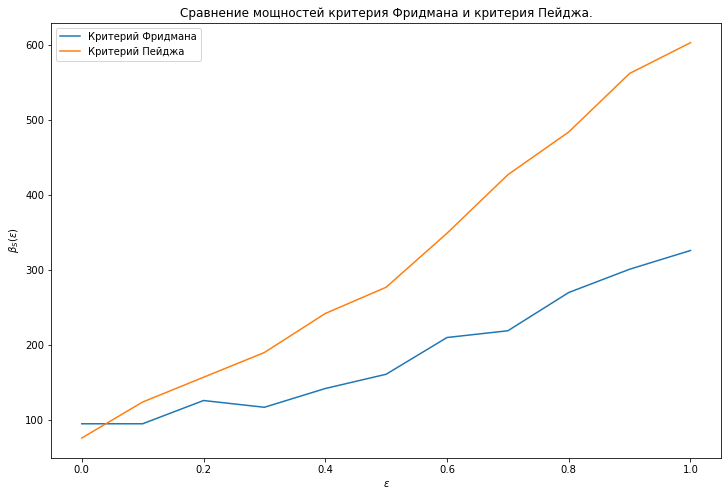

число групп: 5
размер выборки: 100
распределение остатков: $\mathcal{N}(0, 1)$


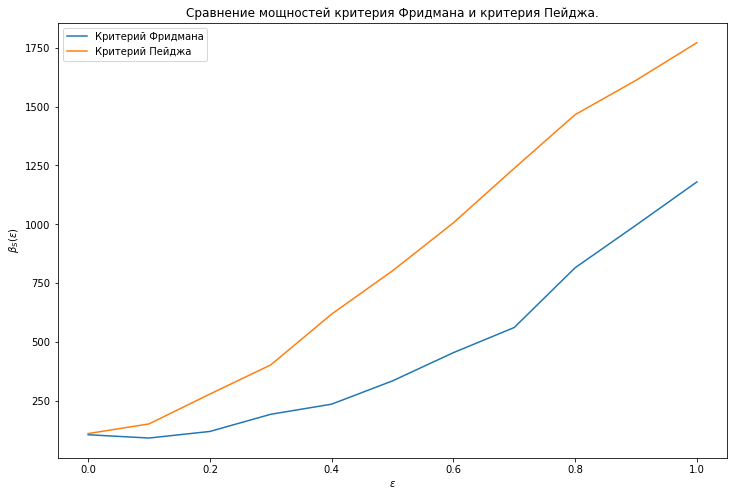

число групп: 7
размер выборки: 100
распределение остатков: $\mathcal{N}(0, 1)$


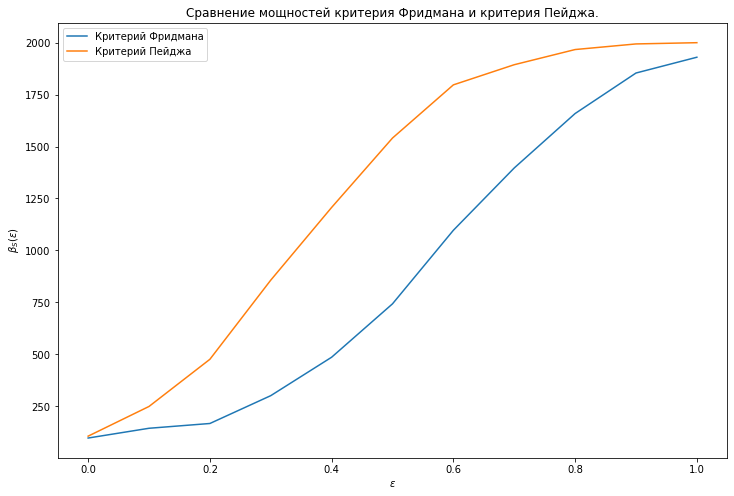

число групп: 10
размер выборки: 100
распределение остатков: $\mathcal{N}(0, 1)$


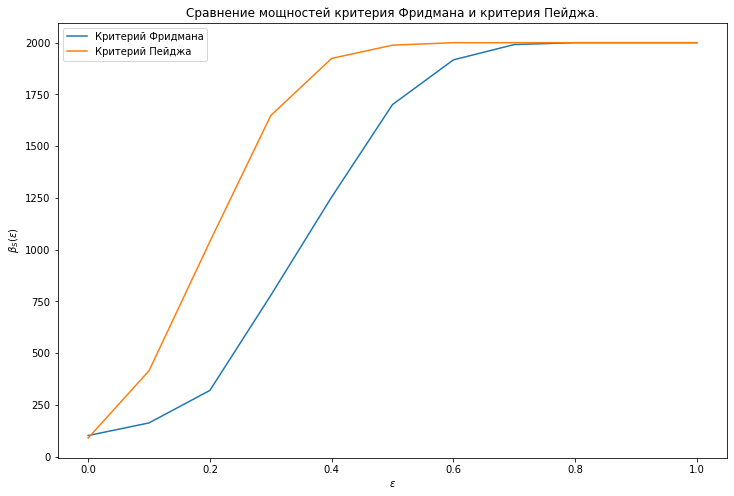

In [149]:
for i, n_factor in enumerate(n_factor_grid):
    print(f'число групп: {n_factor}')
    print('размер выборки: 100')
    print('распределение остатков: $\\mathcal{N}(0, 1)$')
    plt.figure(figsize=(12, 8))
    plt.plot(np.linspace(0, 1, 11), n_rejects_friedman[i][0][0], label='Критерий Фридмана')
    plt.plot(np.linspace(0, 1, 11), n_rejects_page[i][0][0], label='Критерий Пейджа')
    plt.xlabel('$\\epsilon$')
    plt.ylabel('$\\beta_S(\\epsilon)$')
    plt.title(f'Сравнение мощностей критерия Фридмана и критерия Пейджа.')
    plt.legend()
    plt.show()

Видно, что с ростом размера выборки мощность растет, при этом она начинает сильнее расти с ростом эффекта. При этом критерий Пейджа лучше, чем критерий Фридмана, а мощность критерия Фридмана с ростом размера выборки становится более выпуклой.

In [150]:
n_rejects_friedman, n_rejects_page = count_power_factor_criterions(n_sample_grid=n_sample_grid)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

число групп: 10
размер выборки: 10
распределение остатков: $\mathcal{N}(0, 1)$


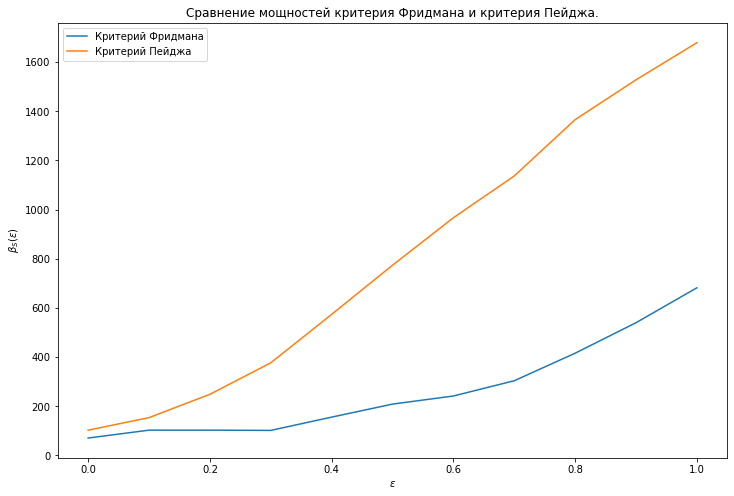

число групп: 10
размер выборки: 20
распределение остатков: $\mathcal{N}(0, 1)$


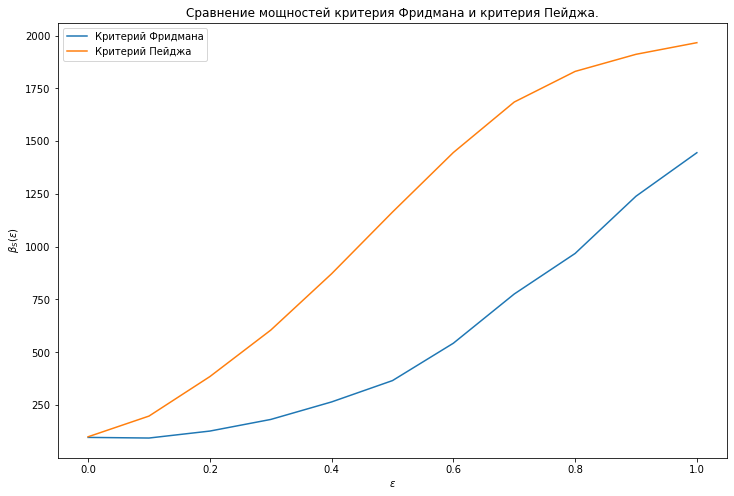

число групп: 10
размер выборки: 30
распределение остатков: $\mathcal{N}(0, 1)$


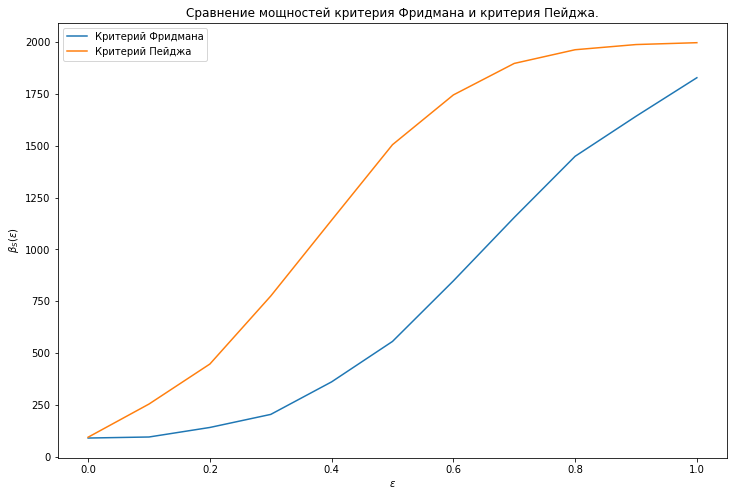

число групп: 10
размер выборки: 50
распределение остатков: $\mathcal{N}(0, 1)$


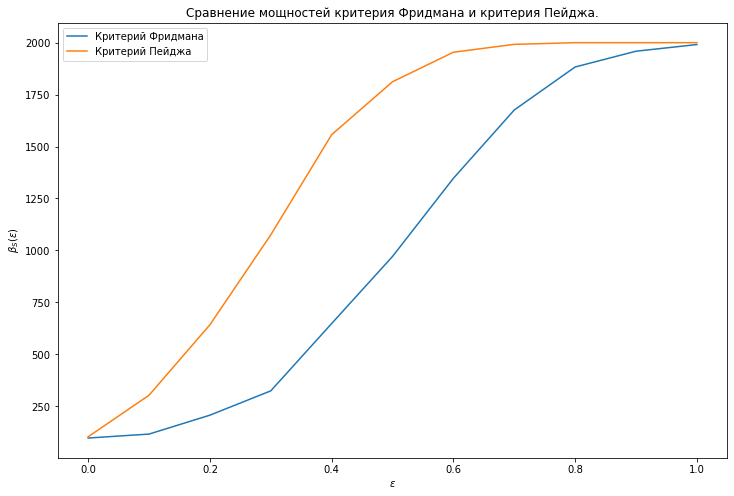

число групп: 10
размер выборки: 100
распределение остатков: $\mathcal{N}(0, 1)$


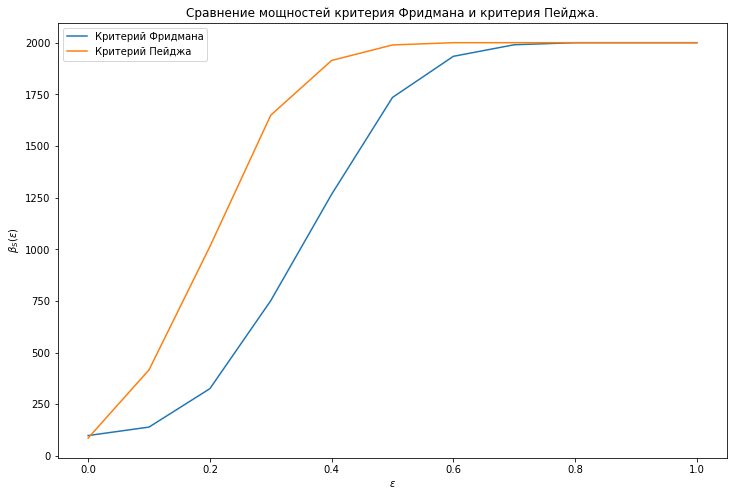

In [151]:
for i, n_sample in enumerate(n_sample_grid):
    print('число групп: 10')
    print(f'размер выборки: {n_sample}')
    print('распределение остатков: $\\mathcal{N}(0, 1)$')
    plt.figure(figsize=(12, 8))
    plt.plot(np.linspace(0, 1, 11), n_rejects_friedman[0][i][0], label='Критерий Фридмана')
    plt.plot(np.linspace(0, 1, 11), n_rejects_page[0][i][0], label='Критерий Пейджа')
    plt.xlabel('$\\epsilon$')
    plt.ylabel('$\\beta_S(\\epsilon)$')
    plt.title(f'Сравнение мощностей критерия Фридмана и критерия Пейджа.')
    plt.legend()
    plt.show()

Аналогичная ситуация и с ростом количества выборок: мощность растет, при этом она начинает сильнее расти с ростом эффекта. При этом критерий Пейджа также лучше, чем критерий Фридмана, а мощность критерия Фридмана также с ростом размера выборки становится более выпуклой.

In [152]:
n_rejects_friedman, n_rejects_page = count_power_factor_criterions(distr_grid=distr_grid)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

число групп: 10
размер выборки: 100
распределение остатков: <scipy.stats._continuous_distns.norm_gen object at 0x000001D807142280>


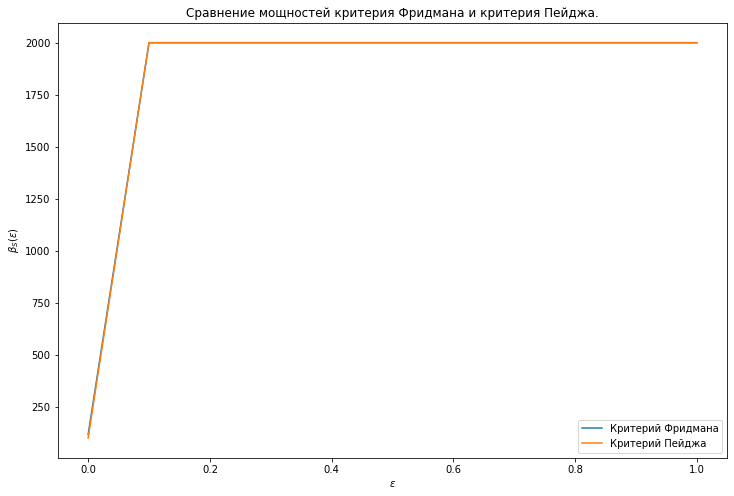

число групп: 10
размер выборки: 100
распределение остатков: <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D80E39EE50>


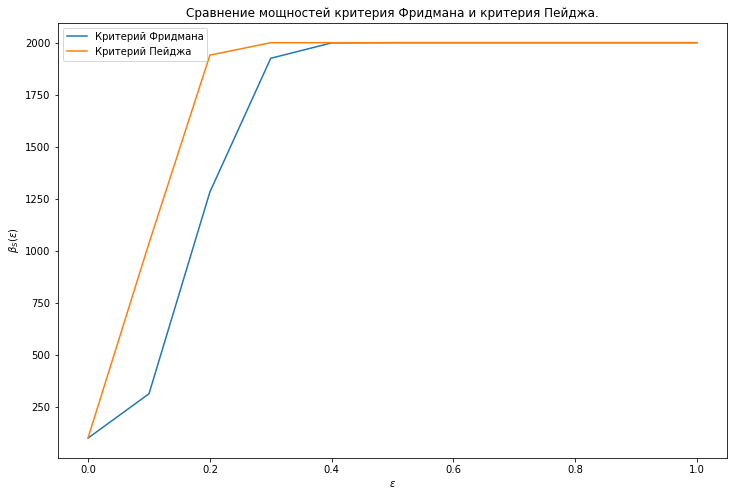

число групп: 10
размер выборки: 100
распределение остатков: <scipy.stats._continuous_distns.laplace_gen object at 0x000001D8071DAD60>


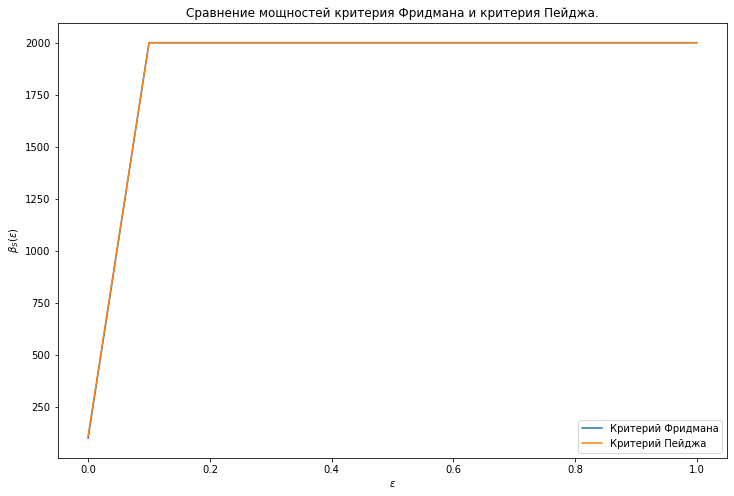

число групп: 10
размер выборки: 100
распределение остатков: <scipy.stats._continuous_distns.cauchy_gen object at 0x000001D8071418B0>


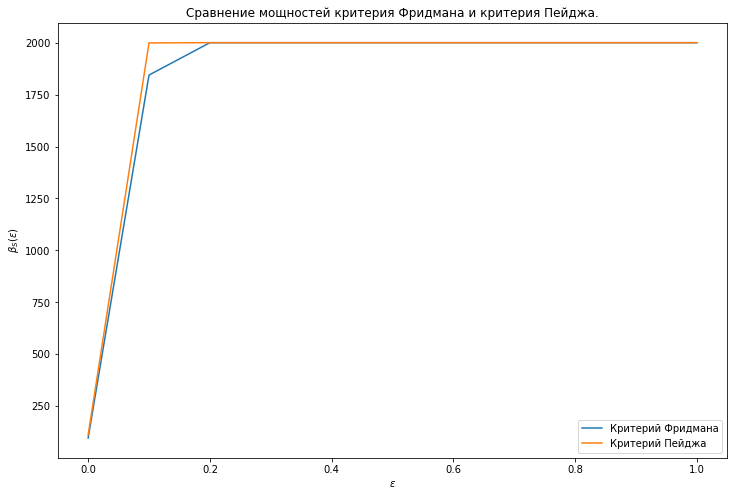

In [153]:
for i, distr in enumerate(distr_grid):
    print('число групп: 10')
    print('размер выборки: 100')
    print(f'распределение остатков: {distr}')
    plt.figure(figsize=(12, 8))
    plt.plot(np.linspace(0, 1, 11), n_rejects_friedman[0][0][i], label='Критерий Фридмана')
    plt.plot(np.linspace(0, 1, 11), n_rejects_page[0][0][i], label='Критерий Пейджа')
    plt.xlabel('$\\epsilon$')
    plt.ylabel('$\\beta_S(\\epsilon)$')
    plt.title(f'Сравнение мощностей критерия Фридмана и критерия Пейджа.')
    plt.legend()
    plt.show()

Видно, что даже сильные выбросы в остатках (даже когда остатки распределены как Коши) не сильно влияют на мощность: она почти максимальная почти сразу же. При этом критерий Фридмана несколько хуже себя показывает, чем критерий Пейджа.

___

In [134]:
data = pd.DataFrame(sm.datasets.fair.load().data)
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [135]:
data.to_csv('fair.csv')